In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.interpolate import interp1d
import seaborn as sns
import os
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pickle

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from ClassFunctions import precip_time_series, rainfall_analysis
from PlottingFunctions import *

## Create object containing rainfall events for one gauge

In [3]:
all_events =[]
for file in os.listdir("../DanishRainData_Outputs"):
    df = pd.read_csv(f"../DanishRainData_Outputs/{file}")
    df['event_num']=range(0, len(df))
    all_events.append(df)
all_events_df = pd.concat(all_events)   

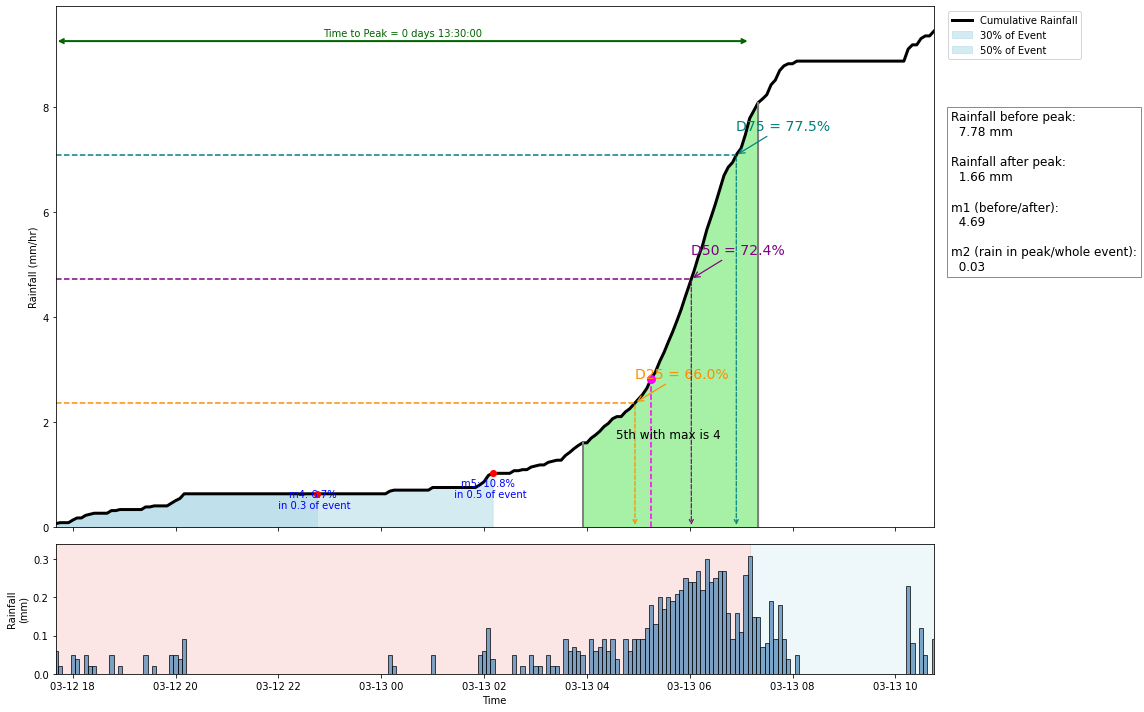

In [5]:
event_id = 0
gauge_id = 598120

file = open(f'/nfs/a319/gy17m2a/MetricEvaluation/DanishRainDataPickles/{gauge_id}_precip_minute.csv.pkl','rb')
object_file = pickle.load(file)

this_gauge_df = all_events_df[all_events_df['gauge_num']==gauge_id]
this_event_df = this_gauge_df[this_gauge_df['event_num']==event_id]
this_event_df.reset_index(inplace=True, drop=True)

event = object_file.raw_events[event_id]
plot_mass_curve_dual(event, this_event_df, '', 'Figures/thisfig.jpg')

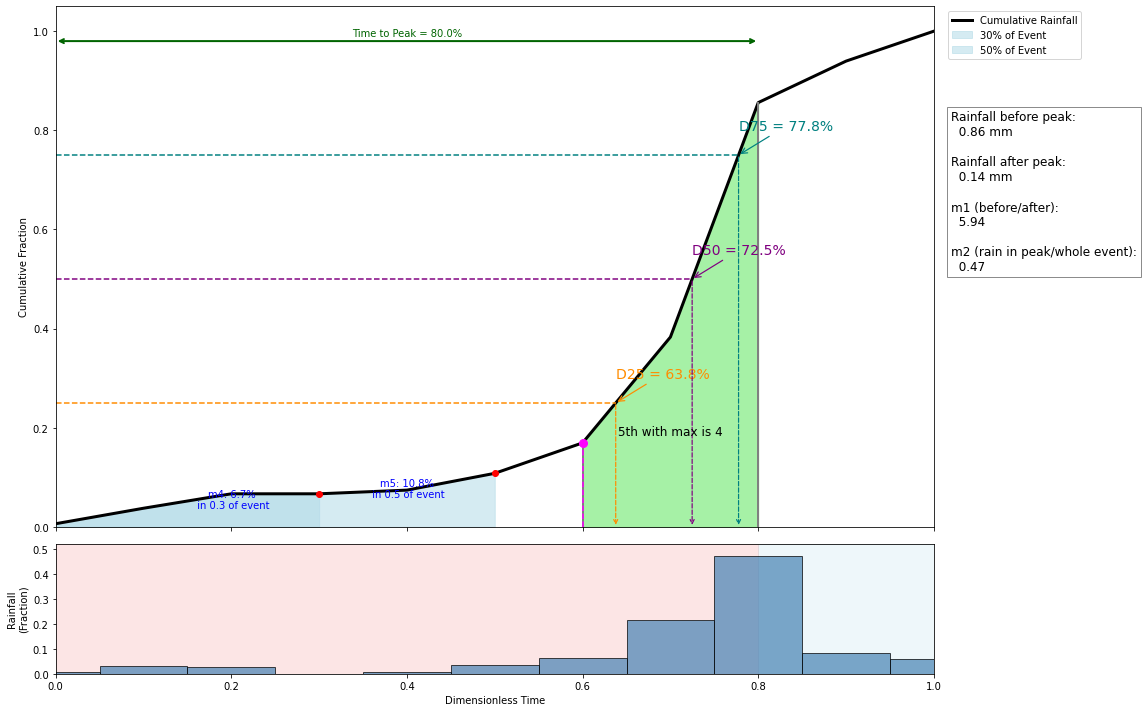

In [8]:
file = open(f'/nfs/a319/gy17m2a/MetricEvaluation/DanishRainDataPickles/{gauge_id}_precip_minute.csv.pkl','rb')
object_file = pickle.load(file)
event = object_file.DMCs[event_id]
plot_mass_curve_dual(event, this_event_df, '_DMC_10', 'Figures/thisfig.jpg')